In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from pathlib import Path
import csv
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
import pdb
import lightgbm as lgb
import xgboost as xgb
import random
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import seaborn as sn
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.covariance import GraphicalLasso
from sklearn.feature_selection import VarianceThreshold
from scipy import linalg

PATH_BASE = Path('../input')
PATH_WORKING = Path('../working')

In [2]:
train = pd.read_csv(PATH_BASE/'train.csv')
test = pd.read_csv(PATH_BASE/'test.csv')

In [3]:
def get_mean_cov(x,y):
    model = GraphicalLasso(max_iter=200)
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [4]:
def projectMeans(means):
    means[means>0]=1
    means[means<=0]=-1
    return means

def _compute_precision_cholesky(covariances, covariance_type):
    estimate_precision_error_message = ("Hell no")
    
    if covariance_type in 'full':
        n_components, n_features, _ = covariances.shape
        precisions_chol = np.empty((n_components, n_features, n_features))
        for k, covariance in enumerate(covariances):
            try:
                cov_chol = linalg.cholesky(covariance, lower=True)
            except linalg.LinAlgError:
                raise ValueError(estimate_precision_error_message)
            precisions_chol[k] = linalg.solve_triangular(cov_chol,
                                                         np.eye(n_features),
                                                         lower=True).T
    
    return precisions_chol

def _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[::n_features + 1] += reg_covar
    return covariances

def _estimate_gaussian_parameters2(X, resp, reg_covar, covariance_type):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    means = projectMeans(means)

    covariances = {"full": _estimate_gaussian_covariances_full}[covariance_type](resp, X, nk, means, reg_covar)
    return nk, means, covariances

class GaussianMixture2(GaussianMixture):
    def _m_step(self, X, log_resp):
        resp = np.exp(log_resp)
        sums = resp.sum(0)
        if sums.max() - sums.min() > 2:
            for i in range(3):
                resp = len(X) * resp / resp.sum(0) / len(sums)
                resp = resp/resp.sum(1)[:,None]
        
        n_samples, _ = X.shape
        self.weights_, self.means_, self.covariances_ = (
            _estimate_gaussian_parameters2(X, resp, self.reg_covar,
                                          self.covariance_type))
        
        self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

        
random.seed(1234)
np.random.seed(1234)
os.environ['PYTHONHASHSEED'] = str(1234)

In [5]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

N_RAND_INIT = 3
N_CLUST_OPT = 3

all_acc = np.zeros((512,N_CLUST_OPT, N_RAND_INIT))

j_selection = np.zeros(N_CLUST_OPT)

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    test_index = range(len(train3))

    yf = train2['target']
    ms, ps = get_mean_cov(train3,yf)

    cc_list = []
    nc_list = [6,4,8]
    for j in range(N_CLUST_OPT):
        cc_list.append(['cluster_' + str(i) for i in range(nc_list[j])])
    
    gm_list = []
    acc = np.zeros((N_CLUST_OPT, N_RAND_INIT))
    res_list = []
    ctc_list = []
    
    for j in range(N_CLUST_OPT):
        gm_list.append([])
        res_list.append([])
        ctc_list.append([])
        
        nc = nc_list[j]
        
        for k in range(N_RAND_INIT):
            if j == 0:
                ps_list = np.concatenate([ps,ps,ps], axis=0)
                
                th = 1.6/4
                th1 = -0.8 + th + 0.5*(np.random.rand(1)-0.5)*th
                th2 = 0.5*(np.random.rand(1)-0.5)*th
                th3 = 0.8 - th + 0.5*(np.random.rand(1)-0.5)*th
                
                ms1 = ms.copy()
                ms1[ms>=th1]=1
                ms1[ms<th1]=-1
                ms2 = ms.copy()
                ms2[ms>=th2]=1
                ms2[ms<th2]=-1
                ms3 = ms.copy()
                ms3[ms>=th3]=1
                ms3[ms<th3]=-1
                ms_list = np.concatenate([ms1,ms2,ms3], axis=0)
            
            if j == 1:
                ps_list = np.concatenate([ps,ps], axis=0)
                
                th = 1.6/3
                th1 = -0.8 + th + 0.5*(np.random.rand(1)-0.5)*th
                th2 = 0.8 - th + 0.5*(np.random.rand(1)-0.5)*th                
                
                ms1 = ms.copy()
                ms1[ms>=th1]=1
                ms1[ms<th1]=-1
                ms2 = ms.copy()
                ms2[ms>=th2]=1
                ms2[ms<th2]=-1
                ms_list = np.concatenate([ms1,ms2], axis=0)
            
            if j == 2:
                ps_list = np.concatenate([ps,ps,ps,ps], axis=0)
                
                th = 1.6/5
                th1 = -0.8 + th + 0.5*(np.random.rand(1)-0.5)*th
                th2 = -0.8 + 2*th + 0.5*(np.random.rand(1)-0.5)*th
                th3 = 0.8 - 2*th + 0.5*(np.random.rand(1)-0.5)*th
                th4 = 0.8 - th + 0.5*(np.random.rand(1)-0.5)*th
                
                ms1 = ms.copy()
                ms1[ms>=th1]=1
                ms1[ms<th1]=-1
                ms2 = ms.copy()
                ms2[ms>=th2]=1
                ms2[ms<th2]=-1
                ms3 = ms.copy()
                ms3[ms>=th3]=1
                ms3[ms<th3]=-1
                ms4 = ms.copy()
                ms4[ms>=th4]=1
                ms4[ms<th4]=-1
                ms_list = np.concatenate([ms1,ms2,ms3,ms4], axis=0)
            
            perm = np.random.permutation(nc)
            ps_list = ps_list[perm]
            ms_list = ms_list[perm]
            
            gm = GaussianMixture2(n_components=nc, init_params='random', covariance_type='full', tol=0.0001,reg_covar=0.001,
                                  max_iter=5000, n_init=1, means_init=ms_list, precisions_init=ps_list, random_state=1234)
            gm.fit(np.concatenate([train3,test3],axis = 0))

            res = pd.concat([pd.DataFrame(gm.predict_proba(train3), columns = cc_list[j]), 
                             yf.to_frame().reset_index(drop=True)], sort=False, axis=1)

            cluster_to_class = res.groupby('target').agg('mean').values.argmax(0)

            res = pd.concat([pd.DataFrame(gm.predict_proba(train3), columns = cc_list[j]), 
                             pd.DataFrame(cluster_to_class, index=cc_list[j], 
                                          columns=['target']).transpose()], sort=False, axis=0).\
                transpose().groupby('target').agg(sum).transpose()
            
            res_list[j].append(res[1])
            gm_list[j].append(gm)
            ctc_list[j].append(cluster_to_class)
            acc[j,k] = (res.values.argmax(1) == yf.values).mean()
            all_acc[i,j,k] = acc[j,k]
    
    best_acc = -1
    best_k = 0
    best_j = 0
    
    best_j = acc.mean(1).argmax()
#    for j in range(N_CLUST_OPT):
#        if j != 0 and acc.mean(1)[0] > acc.mean(1)[j]: continue
    for k in range(N_RAND_INIT):
        if best_acc < acc[best_j,k]:
            best_acc = acc[best_j,k]
            best_k = k
    j_selection[best_j] += 1
    
    res2 = pd.concat([pd.DataFrame(gm_list[best_j][best_k].predict_proba(test3), columns = cc_list[best_j]), 
                      pd.DataFrame(ctc_list[best_j][best_k], index=cc_list[best_j], 
                                   columns=['target']).transpose()], sort=False, axis=0).\
        transpose().groupby('target').agg(sum).transpose()
    
    oof[idx1] = res_list[best_j][best_k]
    preds[idx2] += res2[1]
    
    if i%10==0: print('QMM scores CV =',round(roc_auc_score(train['target'],oof),5))

# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print(j_selection)
print('Final QMM scores CV =',round(auc,5))

QMM scores CV = 0.49997


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.50289
QMM scores CV = 0.5041
QMM scores CV = 0.50594
QMM scores CV = 0.50835
QMM scores CV = 0.51188


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.51565
QMM scores CV = 0.51885
QMM scores CV = 0.52322
QMM scores CV = 0.52709
QMM scores CV = 0.53215
QMM scores CV = 0.53704


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.54209


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.54702
QMM scores CV = 0.55347
QMM scores CV = 0.56031
QMM scores CV = 0.56791
QMM scores CV = 0.57502
QMM scores CV = 0.58178
QMM scores CV = 0.5896
QMM scores CV = 0.59683
QMM scores CV = 0.60511
QMM scores CV = 0.6131
QMM scores CV = 0.62118


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.62951
QMM scores CV = 0.63868
QMM scores CV = 0.64754
QMM scores CV = 0.65689


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.6659


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.67557
QMM scores CV = 0.68606
QMM scores CV = 0.69655


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.70868
QMM scores CV = 0.72007
QMM scores CV = 0.73168
QMM scores CV = 0.74383
QMM scores CV = 0.7562
QMM scores CV = 0.76905
QMM scores CV = 0.78169
QMM scores CV = 0.79516
QMM scores CV = 0.80814


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.82137
QMM scores CV = 0.8351
QMM scores CV = 0.84908


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.86357


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.87854
QMM scores CV = 0.89376
QMM scores CV = 0.909
QMM scores CV = 0.92509


/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


QMM scores CV = 0.94161
QMM scores CV = 0.95792
QMM scores CV = 0.97434

[378.  43.  91.]
Final QMM scores CV = 0.97604


# Submit Predictions

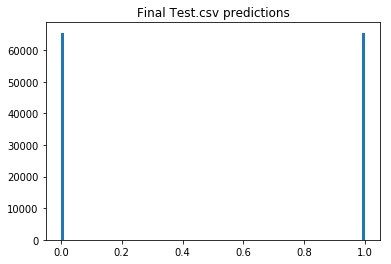

In [6]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()